In [70]:
"""Import statements"""
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import seaborn as sbn

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## ARIMA method as outlined in mod 5 lab

## What is ARIMA?

ARIMA stands for AutoRegressive Integrated Moving Average.
- Popular stats model used to forecast future values in a time series based on past values and errors.

An ARIMA model is defined as ARIMA(p, d, q), where:

- p (AutoRegressive): the number of past values (lags) the model uses to predict the future.
- d (Integrated): the number of times the data is differenced to remove trends and achieve stationarity.
- q (Moving Average): the number of past forecast errors the model uses to correct itself.


In this project, we attempt to forecast the monthly unemployment rate for the San Diego Metropolitan Statistical Area. We utilized ARIMA because:
- The raw unemployment rate shows a non-stationary trend.
- After differencing once (`d = 1`), the series becomes stationary.
- The ACF and PACF plots help identify appropriate values for `p` and `q`.

In [71]:
"""Load data and make it easier to work with """
san_diego = pd.read_csv("../Data/SAND706URN.csv")
san_diego.rename(columns={"SAND706URN": "rate"}, inplace=True)
san_diego.rename(columns={"observation_date": "date"}, inplace=True)
san_diego.set_index("date", inplace=True)
san_diego.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 1990-01-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    424 non-null    float64
dtypes: float64(1)
memory usage: 6.6+ KB


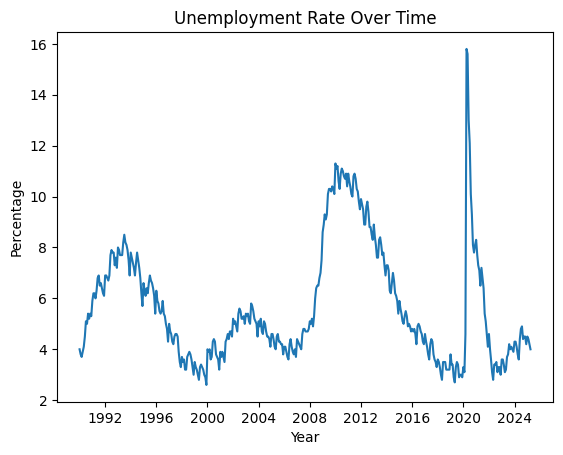

In [72]:
"""Create a time series and plot it to show changes over time"""
plt.title("Unemployment Rate Over Time")
plt.ylabel("Percentage")
plt.xlabel("Year")

time_series = pd.Series(san_diego["rate"].values, index=pd.date_range(start="1990-01-01", periods=len(san_diego), freq="MS"))
plt.plot(time_series)

plt.show()

This line graph displays the monthly unemployment rate in San Diego from 1990 to early 2025.

We see two major spikes:
- 2008-2009 represents the Great Recession
- 2020 represents COVID-19

Overall, the long-term trend remains generally cyclical. There are periods of high and low unemployment. This suggests that seasons and trends are present throughout. This is important for us when we decide whether ARIMA needs seasonal components or differencing.

In [73]:
"""Calculate rolling change from month to month, drop first entry for lack of prior knowledge"""
san_diego["change"] = san_diego["rate"].diff()
san_diego.dropna(inplace=True)
san_diego.head()

,rate,change
date,,
1990-02-01,3.8,-0.2
1990-03-01,3.7,-0.1
1990-04-01,3.9,0.2
1990-05-01,4.1,0.2
1990-06-01,4.5,0.4


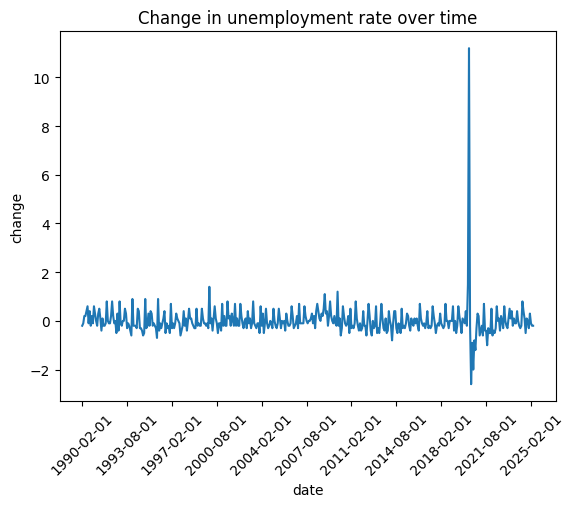

In [74]:
"""Plot rate change over time"""
plot = sbn.lineplot(san_diego, x="date", y="change")
plot.set(title="Change in unemployment rate over time")
plot.xaxis.set_major_locator(plticker.MultipleLocator(base=42.0))

plt.xticks(rotation=45)
plt.show()

This line plot helps visualize how unemployment changes on a monthly basis. Specifically, it displays the volatility and the shifts in trends.

We see that typically the fluctuations hover around 0. The large spikes in either direction represent sudden economic shifts. Sharp rises represent periods of job losses, and sharp drops represent rapid job recovery or even seasonal hiring. The largest spike represents the impact of COVID-19.
It also shows that there is no obvious trend throughout the time period, meaning it supports the stationarity of the differenced series hence why we used d=1 in the ARIMA model.

In [75]:
"""Test for stability using Dickey Fuller test"""
dickey_fuller_raw = adfuller(san_diego["rate"])
dickey_fuller_diff = adfuller(san_diego["change"])

print("Augmented Dickey Fuller test on raw rate data:\n", dickey_fuller_raw)
print("Augmented Dickey Fuller test on change by month:\n", dickey_fuller_diff)

Augmented Dickey Fuller test on raw rate data:
 (-2.68095072096676, 0.07739303070165421, 12, 410, {'1%': -3.4464005219454155, '5%': -2.868615280538588, '10%': -2.570538905413444}, 830.7677065906936)
Augmented Dickey Fuller test on change by month:
 (-5.925719143440321, 2.4464824621893917e-07, 12, 410, {'1%': -3.4464005219454155, '5%': -2.868615280538588, '10%': -2.570538905413444}, 835.756726537898)


Note that for the raw rate data the ADF statistic is not more negative than the critical values, and the p-value is greater than 5%, indicating the data is not stationary

The change data, on the other hand, has an ADF statistic that is less than the critical values and a very low p-value, indicating the data is stationary. We will use the change data for this exercise

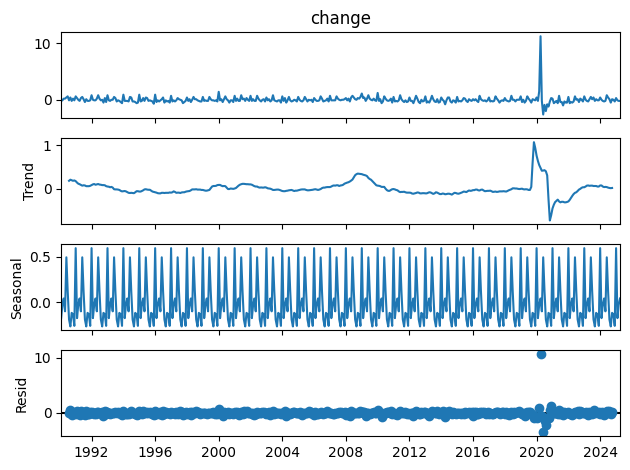

In [76]:
"""Calculate trend, seansonality, and residual"""
decompose_dataset = pd.DataFrame({"change": san_diego["change"], "date": pd.to_datetime(san_diego.index)})
decompose_dataset = decompose_dataset.set_index("date")

decomposition = seasonal_decompose(decompose_dataset["change"], model="additive")
trend = pd.DataFrame(decomposition.trend)
seasonal = pd.DataFrame(decomposition.seasonal)
residual = pd.DataFrame(decomposition.resid)
decomposition.plot()
plt.show()

The above plots arent used directly in ARIMA but simply help us visualize the data to gain a better understanding of seasons trends and residuals.

* Trend: Seems to be flat, with periods of a moderate slope. Shows little long-term drift after differencing
* Seasonal: Appears to have repetitive behaviour showing monthly seasonality
* Residual: Random patterns

The main takeaway is that there is some seasonality, but not enough to require a SARIMA model.

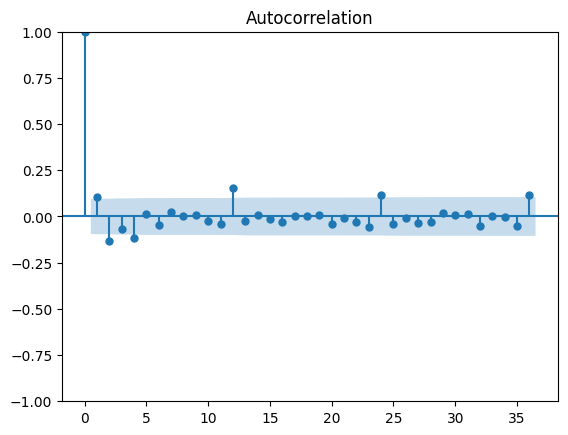

In [77]:
"""Plot the Autocorrelation Function"""
plot_acf(san_diego["change"], lags=36)
plt.show()

The Autocorrelation Function shows us how a time series correlates to its own lagged values. The stronger the correlation between the current value and its past values, the higher the autocrrelation.

We see significant spikes at lags 2, 4, and 12. The lag 12 spike likely indicates seasonality in yearly intervals.

We will use these values as our p as we test for an optimal ARIMA model.

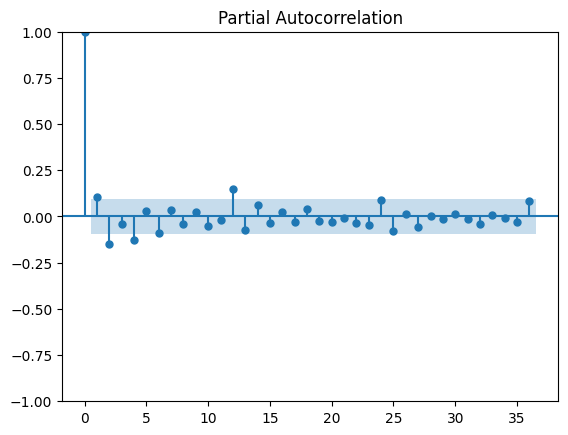

In [78]:
"""Plot the Partial Autocorrelation Function"""
plot_pacf(san_diego["change"], lags=36)
plt.show()

The Partial Autocorrelation Function helps determine the proper parameter for the Moving Average portion of the ARIMA model.

Again, we see significant spikes at 2, 4, and 12.

This gives us our possible q values

In [79]:
"""Divide the data between training and testing data - All but most recent year as training, most recent year as test"""
san_diego_train = san_diego[san_diego.index < "2024-05-01"]
san_diego_test = san_diego[san_diego.index >= "2024-05-01"]

assert len(san_diego_train) + len(san_diego_test) == len(san_diego)
san_diego_train.tail()

,rate,change
date,,
2023-12-01,3.9,-0.1
2024-01-01,4.3,0.4
2024-02-01,4.3,0.0
2024-03-01,4.1,-0.2
2024-04-01,3.8,-0.3


In [80]:
"""Test Fit ARIMA model using info discovered above to find optimal parameters"""
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

possible_p = [2, 4, 12]
d = 1
possible_q = [2, 4, 12]

best_p = None
best_q = None
best_mae = float("inf")

for p in possible_p:
	for q in possible_q:
		arima = ARIMA(san_diego_train["rate"], order=(p, d, q), freq="MS").fit()
		train_preds = arima.predict()
		mae = mean_absolute_error(san_diego_train["rate"][1:], train_preds[1:])
		print(f"MAE for parameters ({p}, {d}, {q}): {mae}")
		if mae < best_mae:
			best_mae = mae
			best_p = p
			best_q = q

print("Optimal parameter:", p, d, q)

MAE for parameters (2, 1, 2): 0.3306414312944107
MAE for parameters (2, 1, 4): 0.325672139095292
MAE for parameters (2, 1, 12): 0.3021236648401679
MAE for parameters (4, 1, 2): 0.3262815985118718
MAE for parameters (4, 1, 4): 0.3208816599432834
MAE for parameters (4, 1, 12): 0.3011811806168524
MAE for parameters (12, 1, 2): 0.2925513513068228
MAE for parameters (12, 1, 4): 0.2906168744075948
MAE for parameters (12, 1, 12): 0.27864767009432445
Optimal parameter: 12 1 12


In [81]:
"""Train model based on optimal parameters"""
arima = ARIMA(san_diego_train["rate"], order=(12, 1, 12), freq="MS").fit()
train_preds = arima.predict()
train_preds

1990-02-01    0.000000
1990-03-01    3.800000
1990-04-01    3.687875
1990-05-01    3.936541
1990-06-01    4.112530
                ...   
2023-12-01    4.096546
2024-01-01    4.127873
2024-02-01    4.068625
2024-03-01    4.109960
2024-04-01    4.277853
Freq: MS, Name: predicted_mean, Length: 411, dtype: float64

In [82]:
"""Make predictions based on model training"""
test_preds = arima.forecast(steps=12)
len(test_preds)

12

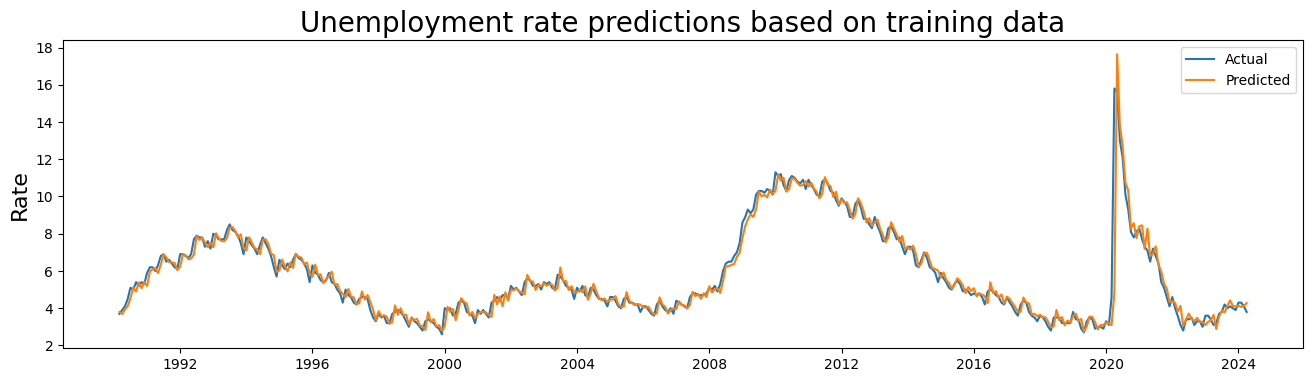

In [83]:
"""Plot the predicted data against the actual data"""
plt.figure(figsize=(16,4))
plt.title("Unemployment rate predictions based on training data", fontsize=20)
plt.ylabel("Rate", fontsize=16)

plt.plot(train_preds.index[1:], san_diego_train["rate"][1:], label="Actual")
plt.plot(train_preds[1:], label="Predicted")

plt.legend()
plt.show()

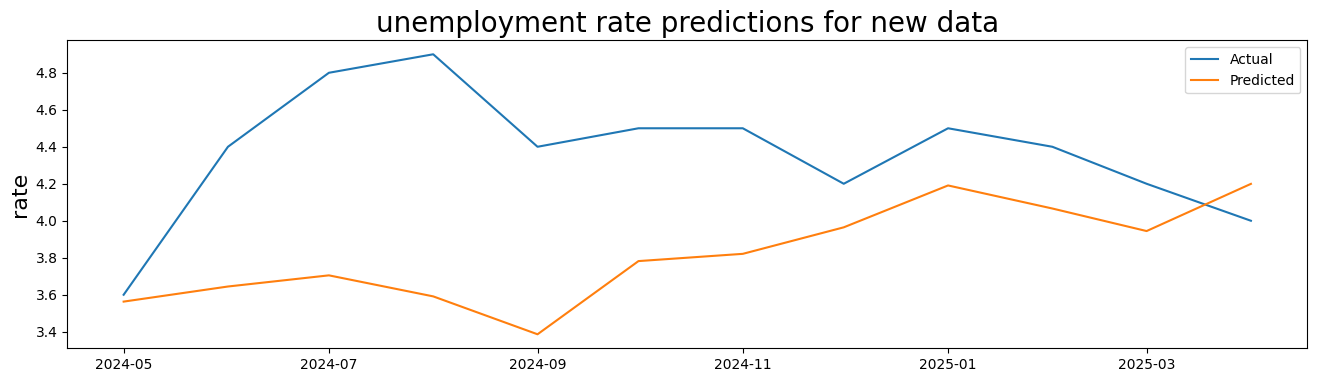

In [84]:
"""Plot the forecast data against the actual data"""
plt.figure(figsize=(16,4))
plt.title("unemployment rate predictions for new data", fontsize=20)
plt.ylabel("rate", fontsize=16)

plt.plot(test_preds.index, san_diego_test["rate"], label="Actual")
plt.plot(test_preds, label="Predicted")

plt.legend()
plt.show()

Above is the forecasted unemployment rates for the next 12 months

In [85]:
"""Calculate a few error statistics for the predictions"""
arima_mae = mean_absolute_error(san_diego_test["rate"], test_preds) # Calculate Mean Absolute Error via ARIMA Method
arima_mse = mean_squared_error(san_diego_test["rate"], test_preds) # Calculate Mean Squared Error via ARIMA Method
arima_rmse = np.sqrt(arima_mse) # Calculate Root Mean Squared Error via ARIMA Method

print(f"ARIMA Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {arima_mae:.3f}")
print(f"  MSE (Mean Standard Error): {arima_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {arima_rmse:.3f}")

ARIMA Method Accuracy:
  MAE (Mean Absolute Error): 0.578
  MSE (Mean Standard Error): 0.488
  RMSE (Root Mean Squared Error): 0.699


## Various methodologies as outlined in [web resource](https://unravelthedata.com/time-series-forecasting-with-unemployment-data/)

### Partitioning

Although we considered the time/train split method, sklearn randomizes its splits and, as a result, is not suitable for time series data.

Time series data requires chronological splitting instead of random sampling, since we need to preserve the order to simulate real-world forecasting scenarios where we predict future values based on historical data. Random sampling could risk our ability to predict relevant to a time series (consider how problematic it woudl be to take random temperatures throughout a year in a location that experiences significant seasonal differences, as an example).

In [86]:
# Partitioning
# The time/train split method from sklearn's train_test_split is not suitable for time series data, it randomizes things.
test_size = max(int(len(time_series) * 0.2), 4)
test = time_series[-test_size:]
print(len(test))
training = time_series[:-test_size]
print(len(training))

# The Partitioning method does not generate MAE and MSE because we're not using a model to do any forecasting in this scenario.

84
340


### Naive Forecasting Method

The naive forecasting method is the simplest time series forecasting approach, where all future values are predicted to be equal to the last observed value in the training data. In effect, the Naive method is a baseline to compare the ARIMA model we worked on above.

In [87]:
# Naive Forecasting Method
def naive_forecast(train_data, forecast_steps): # define the function for naive forecasting
    """
    Naive method: forecast = last observed value
    """
    last_value = train_data.iloc[-1] # Get the last value from the training data
    forecast = np.repeat(last_value, forecast_steps) # Repeat it for the number of forecast steps
    return forecast # Return the forecast array

# Apply naive method
naive_predictions = naive_forecast(training, test_size) # Forecast using the naive method

print("Naive Method Results:")
print(f"  Last training value: {training.iloc[-1]:.2f}") # Display the last value from the training data
print(f"  Forecast (constant): {naive_predictions[0]:.2f}") # Display the constant forecast value
print(f"  All predictions: {naive_predictions}") # Displays all predictions made by this method

# Calculate accuracy
naive_mae = mean_absolute_error(test, naive_predictions) # Calculate Mean Absolute Error
naive_mse = mean_squared_error(test, naive_predictions) # Calculate Mean Squared Error
naive_rmse = np.sqrt(naive_mse) # Calculate Root Mean Squared Error

print(f"\nNaive Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {naive_mae:.3f}")
print(f"  MSE (Mean Squared Error): {naive_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {naive_rmse:.3f}")

Naive Method Results:
  Last training value: 3.00
  Forecast (constant): 3.00
  All predictions: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]

Naive Method Accuracy:
  MAE (Mean Absolute Error): 1.861
  MSE (Mean Squared Error): 10.384
  RMSE (Root Mean Squared Error): 3.222


### Drift Method

The drift method builds upon the naive approach. It incorporates the average historical trend by looking at the previous observations for linear trends, then projects that forward. It is critically important to note that this method assumes the linear trend will be consistent. Originally we built our drift based on the previous two observations, but that is not much different than a naive method, so we updated the code to run a full drift method.

In [88]:
# drift Method
"""Enhanced Drift Method - calculates trend over entire training period"""
def drift_forecast(train_data, forecast_steps): # define the function for drift forecasting
    
    if len(train_data) < 2:
        # Fallback to naive if insufficient data (less than 2 data points)
        return np.repeat(train_data.iloc[-1], forecast_steps) # Repeats the last value if there isn't enough data
    
    # Calculate overall drift rate
    first_value = train_data.iloc[0] # Get the first value from the training data
    last_value = train_data.iloc[-1] # Get the last value from the training data
    total_periods = len(train_data) - 1
    drift_per_period = (last_value - first_value) / total_periods
    
    # Generate forecasts
    forecasts = [] # Initialize an empty list to store forecasts
    for h in range(1, forecast_steps + 1):
        forecast_value = last_value + (h * drift_per_period)
        forecasts.append(forecast_value)
    
    return np.array(forecasts) # Return the forecasts as a numpy array

# Applies the proper drift method to the training data
drift_predictions = drift_forecast(training, test_size)

print("Drift Method Results:")
print(f"  Training start value: {training.iloc[0]:.2f}")
print(f"  Training end value: {training.iloc[-1]:.2f}")
print(f"  Training periods: {len(training)}")
print(f"  Drift per period: {(training.iloc[-1] - training.iloc[0]) / (len(training)-1):.4f}")
print(f"  Drift predictions: ")
print(f"{drift_predictions}")

# Calculate accuracy
drift_mae = mean_absolute_error(test, drift_predictions) # Calculate Mean Absolute Error via Drift Method
drift_mse = mean_squared_error(test, drift_predictions) # Calculate Mean Squared Error via Drift Method
drift_rmse = np.sqrt(drift_mse) # Calculate Root Mean Squared Error via Drift Method

print(f"\nDrift Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {drift_mae:.3f}")
print(f"  MSE (Mean Standard Error): {drift_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {drift_rmse:.3f}")

Drift Method Results:
  Training start value: 4.00
  Training end value: 3.00
  Training periods: 340
  Drift per period: -0.0029
  Drift predictions: 
[2.99705015 2.99410029 2.99115044 2.98820059 2.98525074 2.98230088
 2.97935103 2.97640118 2.97345133 2.97050147 2.96755162 2.96460177
 2.96165192 2.95870206 2.95575221 2.95280236 2.94985251 2.94690265
 2.9439528  2.94100295 2.9380531  2.93510324 2.93215339 2.92920354
 2.92625369 2.92330383 2.92035398 2.91740413 2.91445428 2.91150442
 2.90855457 2.90560472 2.90265487 2.89970501 2.89675516 2.89380531
 2.89085546 2.8879056  2.88495575 2.8820059  2.87905605 2.87610619
 2.87315634 2.87020649 2.86725664 2.86430678 2.86135693 2.85840708
 2.85545723 2.85250737 2.84955752 2.84660767 2.84365782 2.84070796
 2.83775811 2.83480826 2.83185841 2.82890855 2.8259587  2.82300885
 2.820059   2.81710914 2.81415929 2.81120944 2.80825959 2.80530973
 2.80235988 2.79941003 2.79646018 2.79351032 2.79056047 2.78761062
 2.78466077 2.78171091 2.77876106 2.77581121

### Simple Average Method

This method uses the historical mean as the forecast perspective. By using the historical mean of all of the training data observations, this ignores any sort of considerations like seasonal impacts or weekday/weekend type considerations. It's not ideal for time series observations, but gives us a simple baseline.

In [89]:
# Simple Average Method

def simple_average_forecast(train_data, forecast_steps):
    historical_mean = np.mean(train_data)  # Calculate the mean of the training data
    forecast = np.repeat(historical_mean, forecast_steps)  # Repeat the mean for the number of forecast steps
    return forecast  # Return the forecast array

#Apply the simple average method
avg_predictions = simple_average_forecast(training, test_size)

print("Simple Average Method Results:")
print(f"  Historical Mean: {np.mean(training):.2f}")  # Display the mean of the training data
print(f"  Forecast (Constant): {avg_predictions[0]:.2f}")  # Display the constant forecast value
print(f"  All Predictions:")  # Displays all predictions made by this method
print(f"{avg_predictions}")

# Calculate the accuracy of the simple average method
avg_mae = mean_absolute_error(test, avg_predictions)  # Calculate Mean Absolute Error
avg_mse = mean_squared_error(test, avg_predictions)  # Calculate Mean Squared Error
avg_rmse = np.sqrt(avg_mse)  # Calculate Root Mean Squared Error

print(f"\nSimple Average Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {avg_mae:.3f}")
print(f"  MSE (Mean Squared Error): {avg_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {avg_rmse:.3f}")

Simple Average Method Results:
  Historical Mean: 5.91
  Forecast (Constant): 5.91
  All Predictions:
[5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91

### Exponential Smoothing Method

This method is a forecasting technique that appllies exponentially decreasing weights to historical observations. This means that more recent data points are treated with more importance than older ones, but older ones are still considered. The smoothing parameter, alpha, is use to control the rate of decay: higher alpha values weight more recent observations more heavily, while the lower alpha values factor in more historical data points. This method is valuable for considering seasonality, where previous methods might not do well there.

In [90]:
# Exponential Smoothing
smoothing = ExponentialSmoothing(training, seasonal=None).fit() # Fit the Exponential Smoothing model to the training data
smoothing_forecast = smoothing.forecast(test_size) # Forecast the next values using the fitted model

print("Exponential Smoothing Method Results:")
print(f"  Smoothing parameter (alpha): {smoothing.params['smoothing_level']:.3f}")
print(f"  Forecast values: {smoothing_forecast}")

# Calculate accuracy metrics
smoothing_mae = mean_absolute_error(test, smoothing_forecast) # Calculate Mean Absolute Error
smoothing_mse = mean_squared_error(test, smoothing_forecast) # Calculate Mean Squared Error
smoothing_rmse = np.sqrt(smoothing_mse) # Calculate Root Mean Squared Error

print(f"\nExponential Smoothing Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {smoothing_mae:.3f}")
print(f"  MSE (Mean Squared Error): {smoothing_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {smoothing_rmse:.3f}")

Exponential Smoothing Method Results:
  Smoothing parameter (alpha): 0.956
  Forecast values: 2018-05-01    3.013729
2018-06-01    3.013729
2018-07-01    3.013729
2018-08-01    3.013729
2018-09-01    3.013729
                ...   
2024-12-01    3.013729
2025-01-01    3.013729
2025-02-01    3.013729
2025-03-01    3.013729
2025-04-01    3.013729
Freq: MS, Length: 84, dtype: float64

Exponential Smoothing Method Accuracy:
  MAE (Mean Absolute Error): 1.850
  MSE (Mean Squared Error): 10.334
  RMSE (Root Mean Squared Error): 3.215


### Holt Method

This method builds upon exponential smoothing method by adding an additional component, trends. Alpha = level, Beta = trend. The goal of this method is to use both of these smoothing parameters to track both the current value and the rate of change.

In [91]:
# holt Method
holt_model = Holt(training).fit() # Fit the Holt model to the training data
holt_forecast = holt_model.forecast(test_size) # Forecast the next values using the fitted model

print("Holt Method Results:")
print(f"  Alpha (level): {holt_model.params['smoothing_level']:.3f}")
print(f"  Beta (trend): {holt_model.params['smoothing_trend']:.3f}")
print(f"  Forecast values:")
print(f"{holt_forecast}")

# Calculate accuracy metrics
holt_mae = mean_absolute_error(test, holt_forecast) # Calculate Mean Absolute Error
holt_mse = mean_squared_error(test, holt_forecast) # Calculate Mean Squared Error
holt_rmse = np.sqrt(holt_mse) # Calculate Root Mean Squared Error

print(f"\nHolt Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {holt_mae:.3f}")
print(f"  MSE (Mean Squared Error): {holt_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {holt_rmse:.3f}")

Holt Method Results:
  Alpha (level): 0.912
  Beta (trend): 0.057
  Forecast values:
2018-05-01    2.938271
2018-06-01    2.855288
2018-07-01    2.772305
2018-08-01    2.689322
2018-09-01    2.606339
                ...   
2024-12-01   -3.617390
2025-01-01   -3.700373
2025-02-01   -3.783356
2025-03-01   -3.866339
2025-04-01   -3.949322
Freq: MS, Length: 84, dtype: float64

Holt Method Accuracy:
  MAE (Mean Absolute Error): 5.346
  MSE (Mean Squared Error): 38.417
  RMSE (Root Mean Squared Error): 6.198


### Simple Moving Average

This method is similar to the Simple Average Method, although it considers a fixed number of recent observations and then uses that to forecast future periods. It is very biased toward recency and does not do well with large trends or seasonal patterns, as it is considering only the recent past and cannot "look back" at seasonal occurences.

In [100]:
# Simple moving average
def sma_forecast(train_data, forecast_steps): # define the function for naive forecasting
    """
    Simple Moving Average method: forecast = mean observed value
    """
    moving_average_model = np.mean(train_data[:-12]) # Calculate the mean of the 12 most recent steps
    forecast = np.repeat(moving_average_model, forecast_steps) # Repeat the mean for the number of forecast steps
    return forecast # Return the forecast array

sma_predictions = sma_forecast(training, test_size) # Forecast using the sma method

print("SMA Method Results:")
print(f"  Forecast (constant): {sma_predictions[0]:.2f}") # Display the constant forecast value
print(f"  All predictions: {sma_predictions}") # Displays all predictions made by this method

# Calculate accuracy metrics
sma_mae = mean_absolute_error(test, sma_predictions) # Calculate Mean Absolute Error
sma_mse = mean_squared_error(test, sma_predictions) # Calculate Mean Squared Error
sma_rmse = np.sqrt(sma_mse) # Calculate Root Mean Squared Error

print(f"\nsma Method Accuracy:")
print(f"  MAE (Mean Absolute Error): {sma_mae:.3f}")
print(f"  MSE (Mean Squared Error): {sma_mse:.3f}")
print(f"  RMSE (Root Mean Squared Error): {sma_rmse:.3f}")

SMA Method Results:
  Forecast (constant): 5.99
  All predictions: [5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293
 5.99268293 5.99268293 5.99268293 5.99268293 5.99268293 5.9926